# Setup

In [1]:
%cd /content/drive/MyDrive/Universita/MLDL/BiseNetv1/

/content/drive/MyDrive/Universita/MLDL/BiseNetv1


In [2]:
%pwd

'/content/drive/MyDrive/Universita/MLDL/BiseNetv1'

In [3]:
%load_ext autoreload
%autoreload 2

# Downloading both datasets to local disk

In [3]:
%%time
%cd /content
%pwd
!pip install gdown
!gdown https://drive.google.com/u/0/uc?id=1CKtkLRVU4tGbqLSyFEtJMoZV2ZZ2KDeA&export=download
!gdown https://drive.google.com/u/0/uc?id=1GiUjXp1YBvnJjAf1un07hdHFUrchARa0&export=download
!unzip -q CamVid.zip
!unzip -q IDDA.zip
!cp /content/drive/MyDrive/Universita/MLDL/classes_info.json /content/IDDA/classes_info.json
%cd /content/drive/MyDrive/Universita/MLDL/BiseNetv1/

/content
Downloading...
From: https://drive.google.com/u/0/uc?id=1CKtkLRVU4tGbqLSyFEtJMoZV2ZZ2KDeA
To: /content/CamVid.zip
607MB [00:13, 45.9MB/s]
Downloading...
From: https://drive.google.com/u/0/uc?id=1GiUjXp1YBvnJjAf1un07hdHFUrchARa0
To: /content/IDDA.zip
5.26GB [01:28, 59.3MB/s]
/content/drive/My Drive/Universita/MLDL/BiseNetv1
CPU times: user 1.52 s, sys: 340 ms, total: 1.86 s
Wall time: 4min 31s


## Imports

In [7]:
from PIL import Image
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
%config InlineBackend.figure_format = 'retina'

from torchvision import transforms as T
import torch.nn.functional as F
import torch

from utils import reverse_one_hot, colour_code_segmentation

import pandas as pd
from tqdm.notebook import tqdm

## Image visualization utils

In [8]:
mean = torch.tensor([0.485, 0.456, 0.406], dtype=torch.float32)
std = torch.tensor([0.229, 0.224, 0.225], dtype=torch.float32)
unnormalize = T.Normalize((-mean/std).tolist(), (1.0 / std).tolist())

# Parameters

In [9]:
IMAGE_SCALE = (720, 960)
NUM_CLASSES = 12
CONTEXT_PATH = 'resnet18'
BATCH_SIZE = 2

# Experiments

## Load source and target datasets

In [10]:
from dataset.CamVid import CamVid
from dataset.IDDA import IDDA

In [11]:
%%time
source_dataset = IDDA(
    image_path='/content/IDDA/rgb/',
    label_path='/content/IDDA/labels',
    classes_info_path='/content/IDDA/classes_info.json',
    scale=IMAGE_SCALE,
    mode='train'
)

assert len(source_dataset) == 3379
assert len(source_dataset.image_list) == 3379
assert len(source_dataset.label_list) == 3379

target_dataset = CamVid(
    image_path=['/content/CamVid/train/', '/content/CamVid/val/'],
    label_path=['/content/CamVid/train_labels/', '/content/CamVid/val_labels/'],
    csv_path='/content/CamVid/class_dict.csv',
    scale=IMAGE_SCALE,
    mode='train'
)

assert len(target_dataset) == 468
assert len(target_dataset.image_list) == 468
assert len(target_dataset.label_list) == 468

CPU times: user 30.2 ms, sys: 8.33 ms, total: 38.5 ms
Wall time: 61.1 ms


In [12]:
%%time
assert source_dataset[0][0].shape == (3, *IMAGE_SCALE)
assert source_dataset[0][1].shape == (NUM_CLASSES, *IMAGE_SCALE)

assert target_dataset[0][0].shape == (3, *IMAGE_SCALE)
assert target_dataset[0][1].shape == (NUM_CLASSES, *IMAGE_SCALE)

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:258: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


CPU times: user 1.81 s, sys: 147 ms, total: 1.96 s
Wall time: 2.04 s


## Dataloaders

In [13]:
from torch.utils.data import DataLoader

In [14]:
%%time
source_dataloader = DataLoader(
    source_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True,
    pin_memory=True
)

target_dataloader = DataLoader(
    target_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True,
    pin_memory=True
)

CPU times: user 137 µs, sys: 27 µs, total: 164 µs
Wall time: 170 µs


## BiSeNet

### Build model

In [15]:
from model.build_BiSeNet import BiSeNet

In [16]:
%%time
model = BiSeNet(NUM_CLASSES, CONTEXT_PATH)
model.train()

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to /root/.cache/torch/hub/checkpoints/resnet101-5d3b4d8f.pth



CPU times: user 1.78 s, sys: 1.05 s, total: 2.82 s
Wall time: 4.38 s


### Load a source image, label batch

In [17]:
%%time
source_image_batch, source_label_batch = next(iter(source_dataloader))

CPU times: user 2.05 s, sys: 1.07 s, total: 3.13 s
Wall time: 6.43 s


In [18]:
assert source_image_batch.shape == (BATCH_SIZE, 3, *IMAGE_SCALE)

### Run the model on the source image

In [19]:
%%time
source_output_batch, source_auxiliary_supervision_1, source_auxiliary_supervision_2 = model(source_image_batch)

CPU times: user 2.81 s, sys: 677 ms, total: 3.49 s
Wall time: 3.58 s


In [20]:
assert source_output_batch.shape == (BATCH_SIZE, NUM_CLASSES, *IMAGE_SCALE)

### Load a target image, label batch

In [21]:
%%time
target_image_batch, target_label_batch = next(iter(target_dataloader))

CPU times: user 1.59 s, sys: 139 ms, total: 1.73 s
Wall time: 1.73 s


In [22]:
assert target_image_batch.shape == (BATCH_SIZE, 3, *IMAGE_SCALE)

### Run the model on the target image

In [23]:
%%time
target_output_batch, target_auxiliary_supervision_1, target_auxiliary_supervision_2 = model(target_image_batch)

CPU times: user 2.84 s, sys: 564 ms, total: 3.41 s
Wall time: 3.4 s


In [24]:
assert target_output_batch.shape == (BATCH_SIZE, NUM_CLASSES, *IMAGE_SCALE)

### Visualize predictions and ground truths

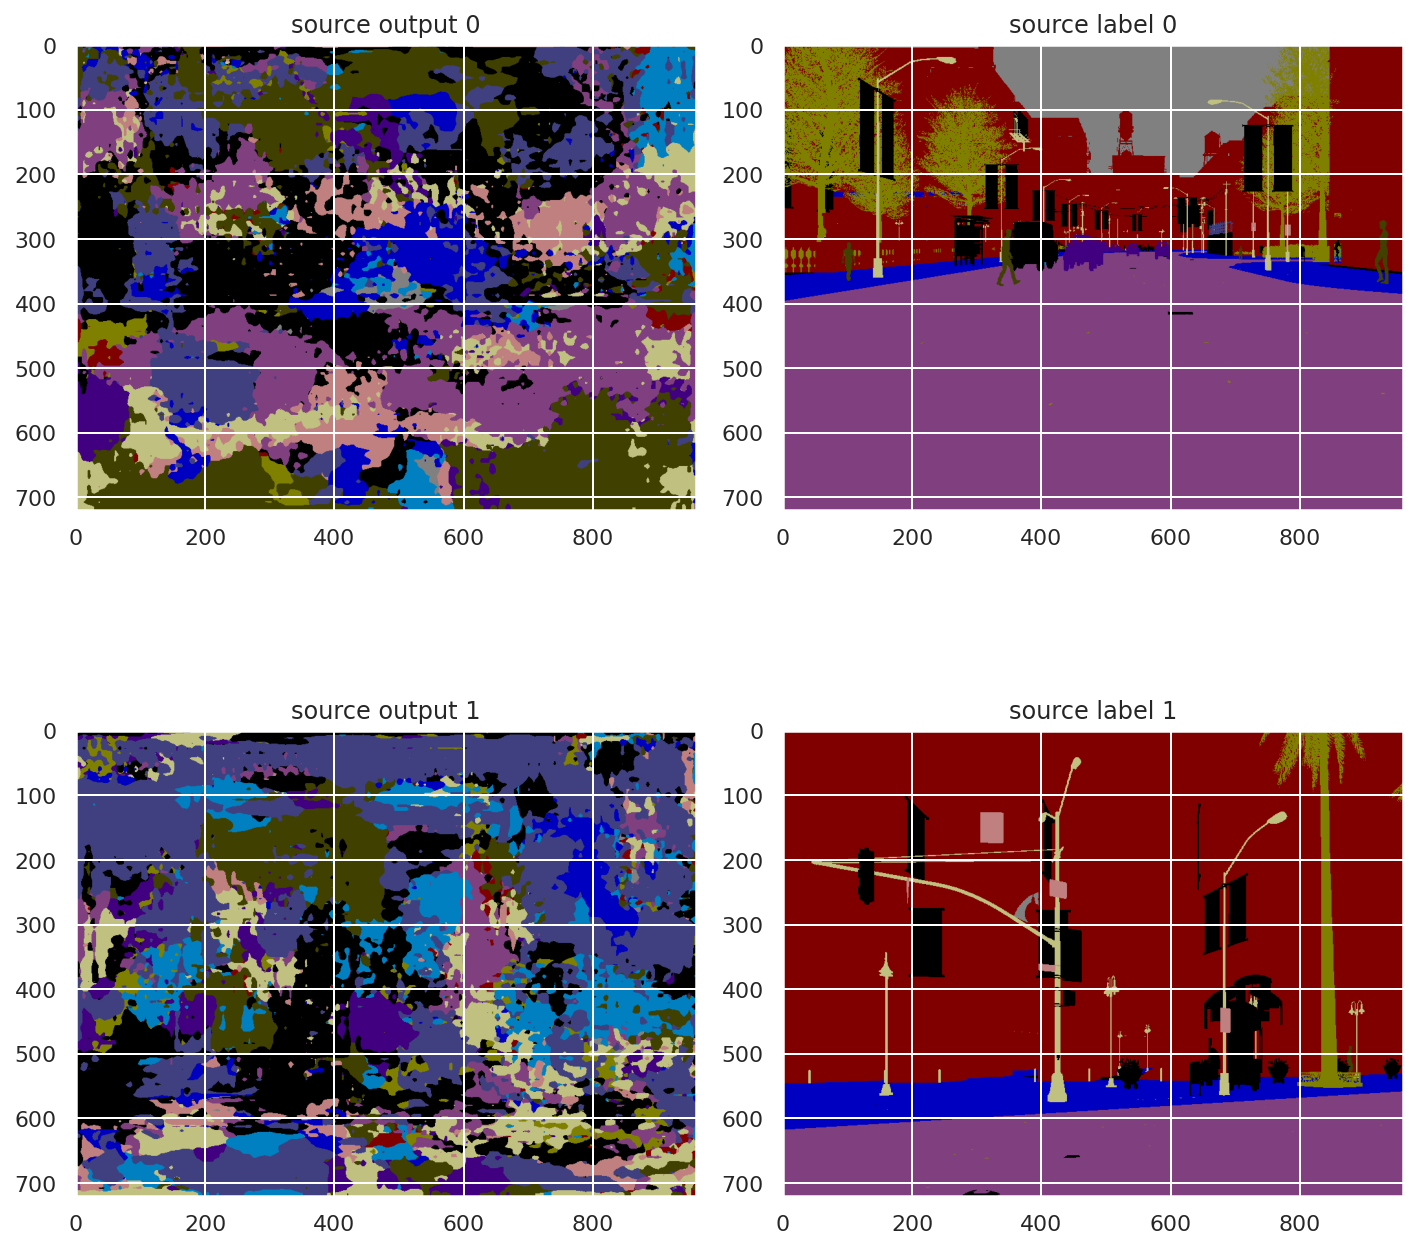

In [54]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 10))
ax1.set_title("source output 0")
ax1.imshow(colour_code_segmentation(reverse_one_hot(source_output_batch[0]).numpy(), target_dataset.label_info))
ax2.set_title("source label 0")
ax2.imshow(colour_code_segmentation(reverse_one_hot(source_label_batch[0]).numpy(), target_dataset.label_info))
ax3.set_title("source output 1")
ax3.imshow(colour_code_segmentation(reverse_one_hot(source_output_batch[1]).numpy(), target_dataset.label_info))
ax4.set_title("source label 1")
ax4.imshow(colour_code_segmentation(reverse_one_hot(source_label_batch[1]).numpy(), target_dataset.label_info))
fig.tight_layout()

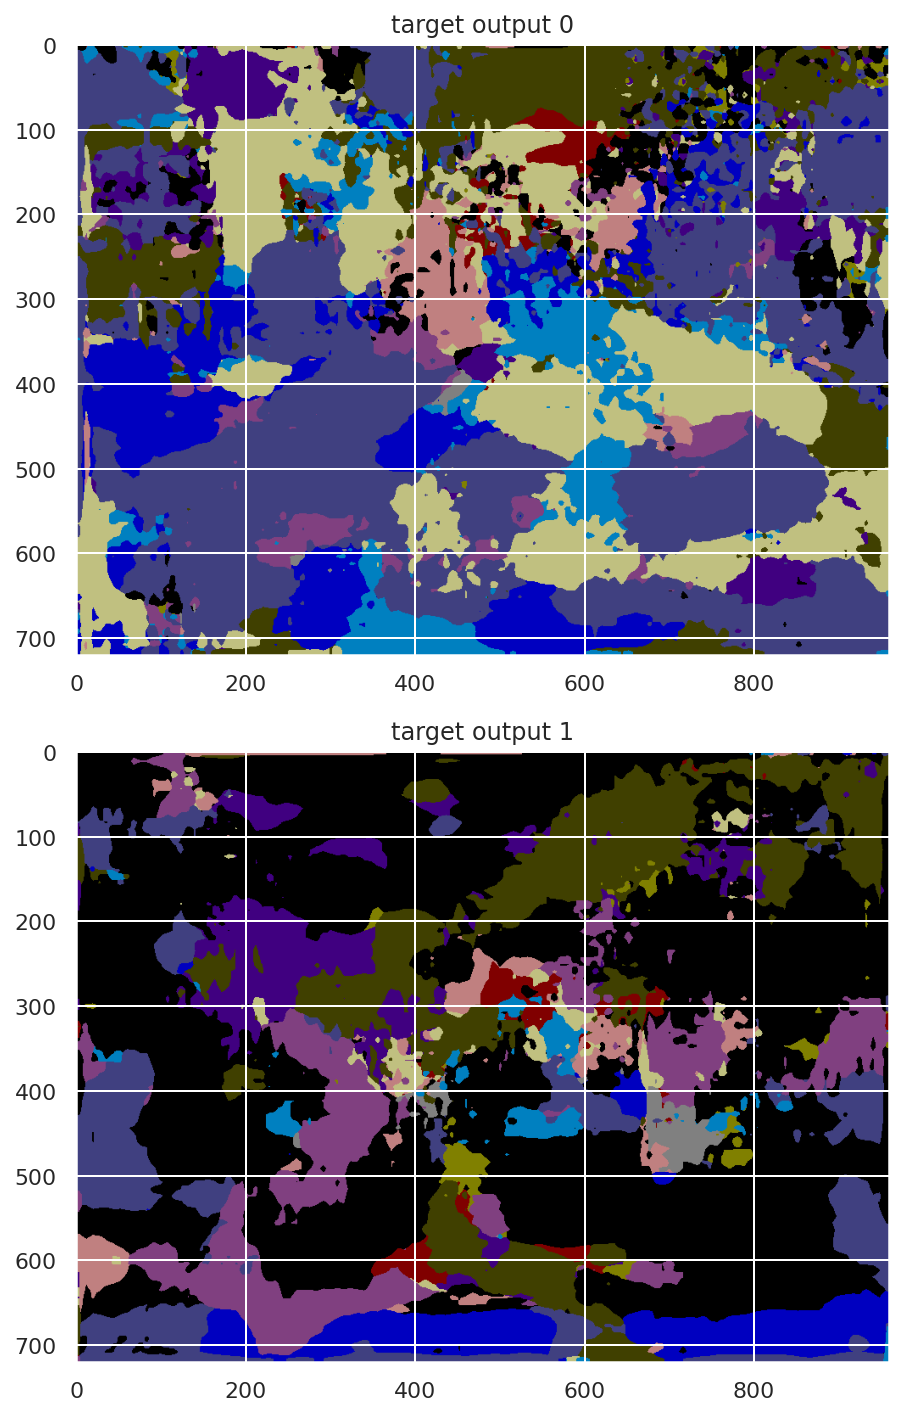

In [26]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))
ax1.set_title("target output 0")
ax1.imshow(colour_code_segmentation(reverse_one_hot(target_output_batch[0]).numpy(), target_dataset.label_info))
ax2.set_title("target output 1")
ax2.imshow(colour_code_segmentation(reverse_one_hot(target_output_batch[1]).numpy(), target_dataset.label_info))
fig.tight_layout()

## Losses

### Define CrossEntropy2D (based on [`CrossEntropyLoss`](https://pytorch.org/docs/master/generated/torch.nn.CrossEntropyLoss.html#torch.nn.CrossEntropyLoss))

Essentially log-SoftMax + Negative log likelihood loss combined

In [27]:
# Taken from https://github.com/wasidennis/AdaptSegNet/blob/fca9ff0f09dab45d44bf6d26091377ac66607028/train_gta2cityscapes_multi.py#L143

import torch.nn as nn
from torch.autograd import Variable


class CrossEntropy2d(nn.Module):

    def __init__(self, size_average=True, ignore_label=11):
        super(CrossEntropy2d, self).__init__()
        self.size_average = size_average
        self.ignore_label = ignore_label

    def forward(self, predict, target, weight=None):
        """
            Args:
                predict:(n, c, h, w)
                target:(n, h, w)
                weight (Tensor, optional): a manual rescaling weight given to each class.
                                           If given, has to be a Tensor of size "nclasses"
        """
        assert not target.requires_grad
        assert predict.dim() == 4
        assert target.dim() == 3
        assert predict.size(0) == target.size(0), "{0} vs {1} ".format(predict.size(0), target.size(0))
        assert predict.size(2) == target.size(1), "{0} vs {1} ".format(predict.size(2), target.size(1))
        assert predict.size(3) == target.size(2), "{0} vs {1} ".format(predict.size(3), target.size(3))
        n, c, h, w = predict.size()
        target_mask = (target >= 0) * (target != self.ignore_label)
        target = target[target_mask]
        if not target.data.dim():
            return Variable(torch.zeros(1))
        predict = predict.transpose(1, 2).transpose(2, 3).contiguous()
        predict = predict[target_mask.view(n, h, w, 1).repeat(1, 1, 1, c)].view(-1, c)
        loss = F.cross_entropy(predict, target, weight=weight, size_average=self.size_average)
        return loss

def calculate_segmentation_loss(pred, label, gpu):
    """
    This function returns cross entropy loss for semantic segmentation
    """
    # out shape batch_size x channels x h x w -> batch_size x channels x h x w
    # label shape h x w x 1 x batch_size  -> batch_size x 1 x h x w
    label = Variable(label.long()).cuda(gpu)
    criterion = CrossEntropy2d().cuda(gpu)

    return criterion(pred, label)

In [28]:
source_output_batch[0, :, 0, 0]

tensor([ 0.1127,  0.5589, -0.1073, -0.4815,  0.8651,  0.8502,  0.1794, -0.4289,
        -1.2043, -0.3947,  0.6466, -0.1091], grad_fn=<SelectBackward>)

In [29]:
source_label_batch.shape, source_output_batch.shape

(torch.Size([2, 12, 720, 960]), torch.Size([2, 12, 720, 960]))

### Understanding CrossEntropyLoss

In [30]:
CrossEntropy2d()(
  source_output_batch,
  np.argmax(source_label_batch, axis=1) # Go from one hot enc to ordinal enc
)

tensor(3.2385, grad_fn=<NllLossBackward>)

In [31]:
# 🤔🤔🤔🤔🤔
CrossEntropy2d()(
  source_label_batch,
  np.argmax(source_label_batch, axis=1) # Go from one hot enc to ordinal enc
)

tensor(1.6224)

In [32]:
F.cross_entropy(
    torch.tensor([
              [0, 0, 100],
              [0, 100, 0],
              [100, 0, 0]
    ]).float(),
    torch.argmax(torch.tensor([
              [0, 0, 100],
              [0, 100, 0],
              [100, 0, 0]
    ]).float(), dim=1)
)

tensor(0.)

In [52]:
# ✔✔✔✔✔
CrossEntropy2d()(
  source_label_batch * 100,
  np.argmax(source_label_batch, axis=1) # Go from one hot enc to ordinal enc
)

tensor(0.)

## Training the generator (just for testing, no adversarial yet)

### Train Generator (on GPU)

In [35]:
torch.cuda.empty_cache()

In [36]:
!nvidia-smi

Sat May 29 09:11:43 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    31W / 250W |    895MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [37]:
model = BiSeNet(NUM_CLASSES, CONTEXT_PATH)
model.train()
model.cuda()
generator_optimizer = torch.optim.SGD(model.parameters(), lr=2.5e-4, momentum=0.9, weight_decay=0.0005)

In [38]:
cross_entropy_loss = CrossEntropy2d()

In [53]:
model.load_state_dict(torch.load('/content/drive/MyDrive/BiSeNetV1_seg_loss_epoch_19_SGD.pth'))

<All keys matched successfully>

In [40]:
# torch.save(model.state_dict(), '/content/drive/MyDrive/BiSeNetV1_seg_loss_epoch_19_SGD.pth')

In [41]:
for epoch in range(0, 6):
  model.train()

  tq = tqdm(total=(len(source_dataloader) * BATCH_SIZE))
  tq.set_description(f"epoch {epoch}")

  # Training loop
  for i, (I_s, Y_s) in enumerate(source_dataloader):
    I_s, Y_s = I_s.cuda(), Y_s.cuda()
    
    # Train generator G
    generator_optimizer.zero_grad()
    
    ## Train G with source s
    P_s, _, _ = model(I_s)
    L_seg = cross_entropy_loss(P_s, torch.argmax(Y_s, dim=1))
    L_seg.backward()

    tq.update(BATCH_SIZE)
    tq.set_postfix(loss='%.6f' % L_seg)

    generator_optimizer.step()
  
  # Evaluation loop

  
  tq.close()

KeyboardInterrupt: ignored

### Evaluate generator

In [ ]:
from utils import fast_hist, per_class_iu

In [ ]:
%%time


def compute_pixel_accuracy_and_mIoU(model, dataloader, samples=100):
  with torch.no_grad():

    model.eval()
    
    pixel_accuracies = []

    class_histogram = np.zeros((NUM_CLASSES, NUM_CLASSES))

    for i, (X, Y) in tqdm(enumerate(dataloader), total=samples):
      if i > samples: break
      X, Y = X.cuda(), Y.cuda()
      Y_hat = model(X)

      Y_hat_labels = torch.argmax(Y_hat, dim=1)
      Y_labels = torch.argmax(Y, dim=1)
      
      for Y_hat_label, Y_label in zip(Y_hat_labels, Y_labels):
        Y_label_flat = Y_label.flatten()
        Y_hat_label_flat = Y_hat_label.flatten()
        pixel_accuracies.append(
          (Y_label_flat == Y_hat_label_flat).float().mean().item()
        )

        class_histogram += fast_hist(
            Y_label_flat.cpu().numpy(),
            Y_hat_label_flat.cpu().numpy(),
            NUM_CLASSES
        )
      
    return np.mean(pixel_accuracies), np.mean(per_class_iu(class_histogram)[:-1])


source_dataloader_iter = iter(source_dataloader)
print(compute_pixel_accuracy_and_mIoU(model, source_dataloader_iter))

**Preliminary results**

What I expect is something like this:
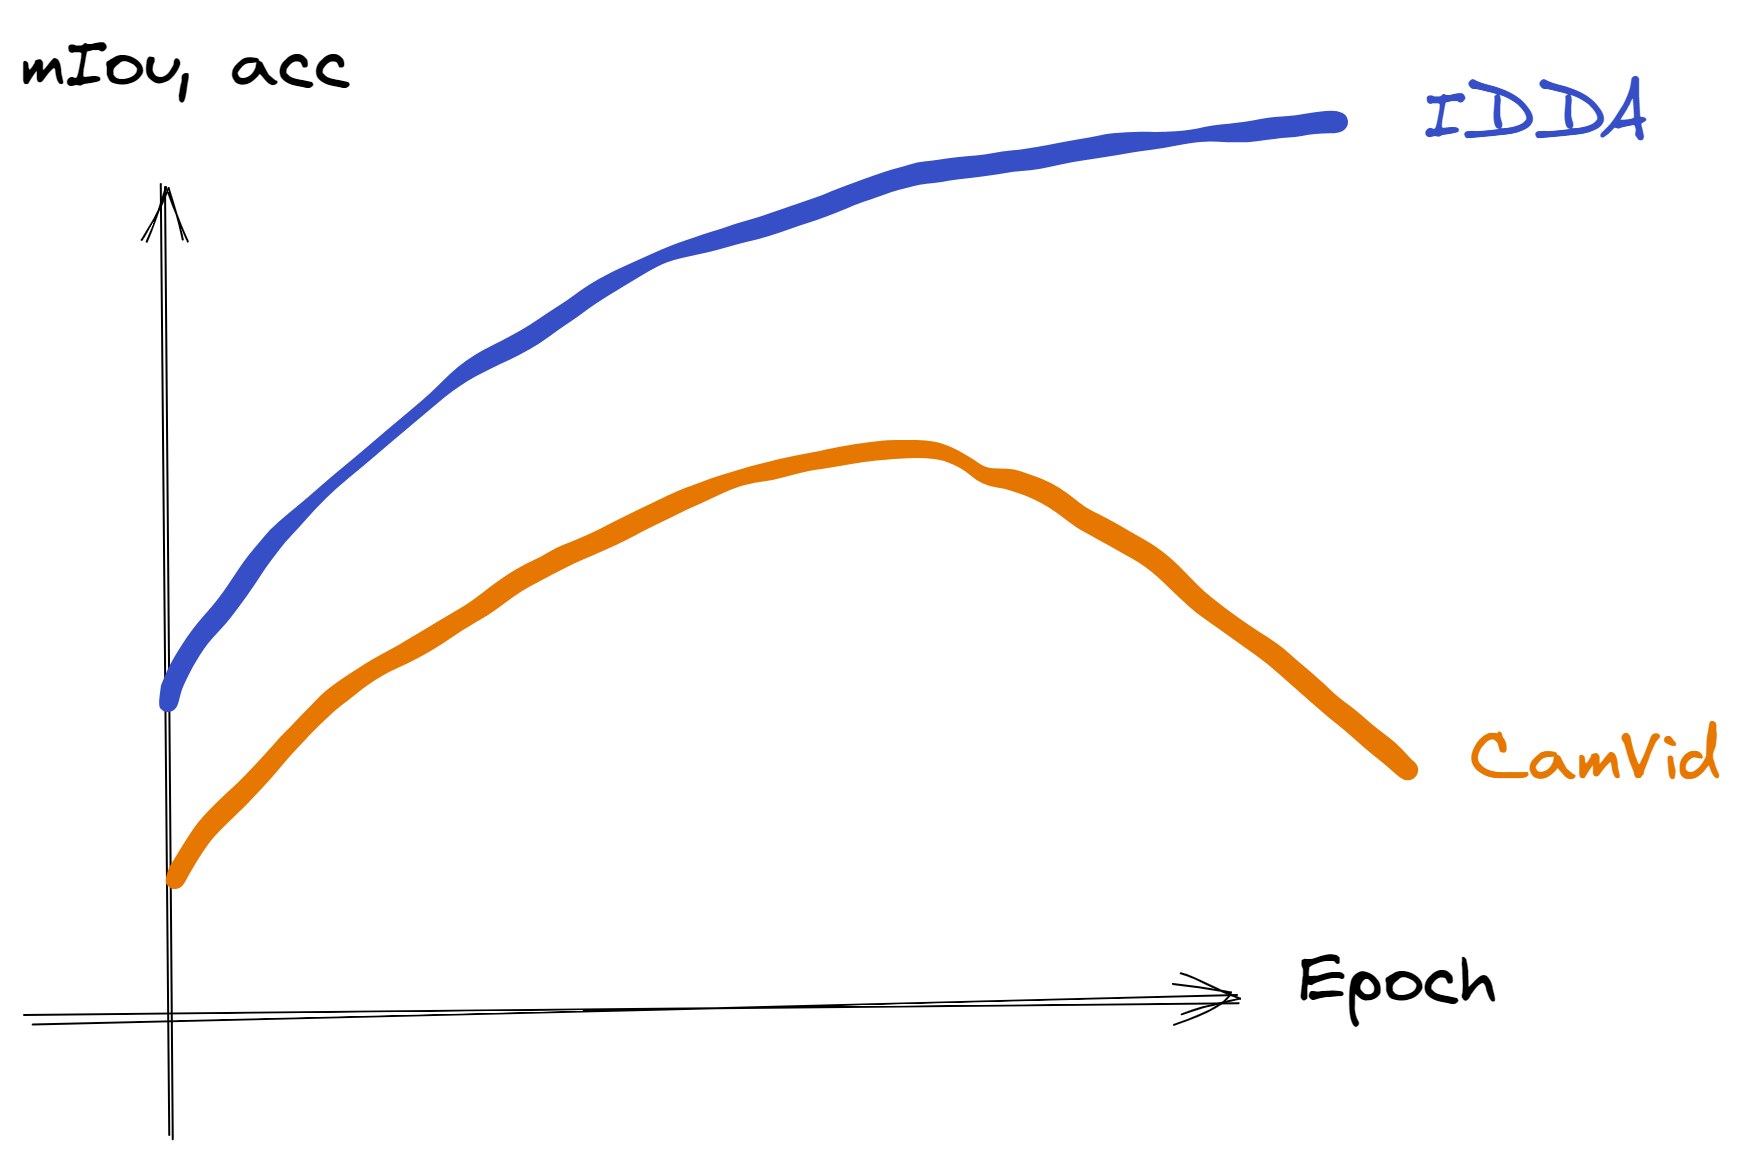

```
 0 epochs, IDDA  , 200 images, acc = 0.003, mIoU = 0.000
 0 epochs, CamVid, 200 images, acc = 0.001, mIoU = 0.003
 2 epochs, IDDA  , 200 images, acc = 0.741, mIoU = 0.384
 2 epochs, CamVid, 200 images, acc = 0.568, mIoU = 0.234
```

```
15 IDDA (0.7454614986730094, 0.37430565352258716)
15 CamVid (0.5005499678802224, 0.20463216321081373)

16 IDDA (0.7774516745369033, 0.41174019299585624)
16 CamVid (0.5467195718244898, 0.2306944294777619)

17 IDDA (0.7435397294783356, 0.3795883954700185)
17 CamVid (0.5214592138729474, 0.21066130248297962)

18 IDDA (0.7583972464988727, 0.41008120418323096)
18 CamVid (0.5743403265455572, 0.23681635077613583)

19 IDDA (0.7781041413545609, 0.4298208841142644)
19 CamVid (0.5368996432217041, 0.22590874121995802)

```

### Experiment 1: When do IDDA and CamVid's performances begin differing?

In [ ]:
for epoch in range(15, 25):
  model.train()

  source_dataloader_iter = iter(source_dataloader)
  target_dataloader_iter = iter(target_dataloader)

  tq = tqdm(total=(len(source_dataloader) * BATCH_SIZE))
  tq.set_description(f"epoch {epoch}")

  # Training loop
  for i, (I_s, Y_s) in enumerate(source_dataloader_iter):
    I_s, Y_s = I_s.cuda(), Y_s.cuda()
    
    # Train generator G
    generator_optimizer.zero_grad()
    
    ## Train G with source s
    P_s, _, _ = model(I_s)
    L_seg = cross_entropy_loss(P_s, torch.argmax(Y_s, dim=1))
    L_seg.backward()

    tq.update(BATCH_SIZE)
    tq.set_postfix(loss='%.6f' % L_seg)

    generator_optimizer.step()
  
  source_dataloader_iter = iter(source_dataloader)
  target_dataloader_iter = iter(target_dataloader)

  # Evaluation loop
  print(epoch, 'IDDA', compute_pixel_accuracy_and_mIoU(model, source_dataloader_iter))
  print(epoch, 'CamVid', compute_pixel_accuracy_and_mIoU(model, target_dataloader_iter))
  
  tq.close()

### Visualize predictions and ground thruths

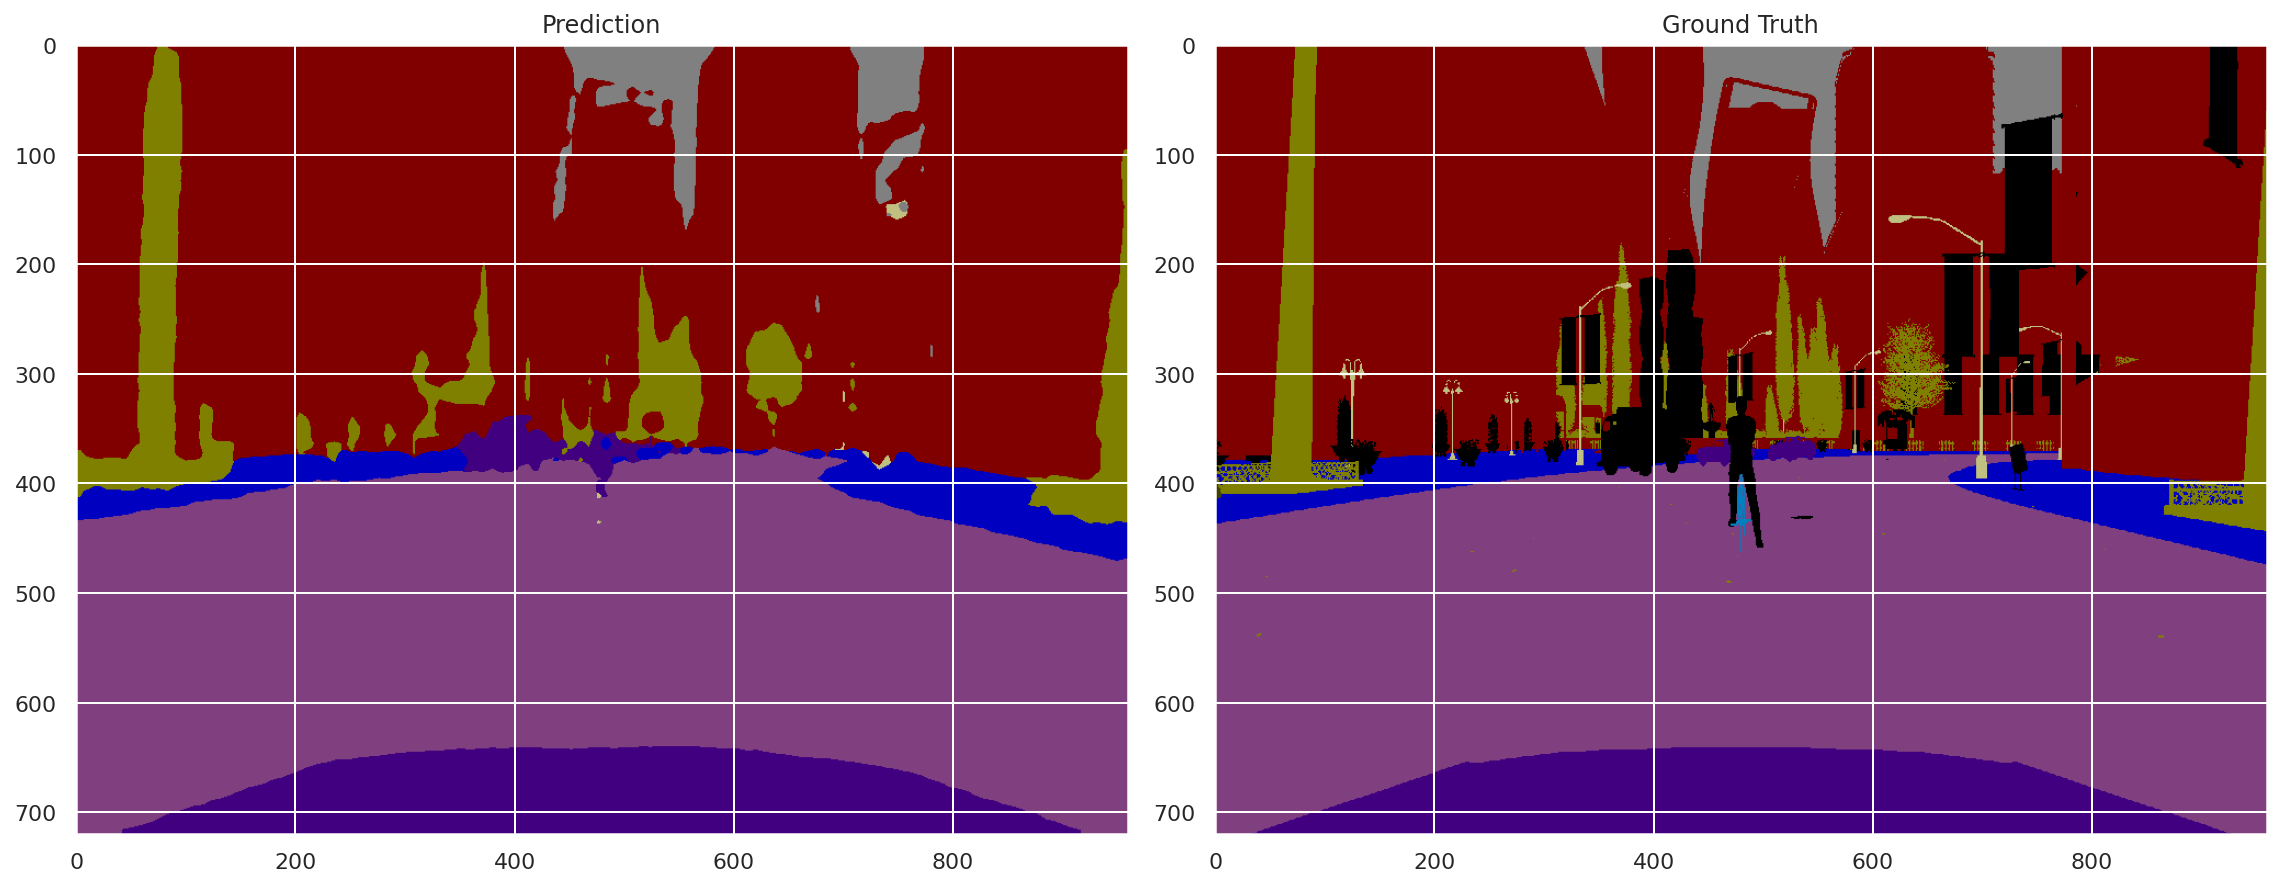

In [58]:
I_s, Y_s = source_dataset[np.random.randint(len(source_dataset))]
I_s, Y_s = I_s.unsqueeze(0).cuda(), Y_s.unsqueeze(0).cuda()
with torch.no_grad():
  model.eval()
  P_s = model(I_s)
  fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16, 16))
  ax1.set_title("Prediction")
  ax1.imshow(colour_code_segmentation(reverse_one_hot(P_s[0, :, :, :]).cpu().numpy(), target_dataset.label_info))
  ax2.set_title("Ground Truth")
  ax2.imshow(colour_code_segmentation(reverse_one_hot(Y_s[0, :, :, :]).cpu().numpy(), target_dataset.label_info))
  fig.tight_layout()

## Training the discriminator (just for testing)

### Define discriminator

In [ ]:
import torch.nn as nn
import torch.nn.functional as F


class FCDiscriminator(nn.Module):
  def __init__(self, num_classes, ndf = 64):
    super(FCDiscriminator, self).__init__()

    self.conv1 = nn.Conv2d(num_classes, ndf, kernel_size=4, stride=2, padding=1)
    self.conv2 = nn.Conv2d(ndf, ndf*2, kernel_size=4, stride=2, padding=1)
    self.conv3 = nn.Conv2d(ndf*2, ndf*4, kernel_size=4, stride=2, padding=1)
    self.conv4 = nn.Conv2d(ndf*4, ndf*8, kernel_size=4, stride=2, padding=1)
    self.classifier = nn.Conv2d(ndf*8, 1, kernel_size=4, stride=2, padding=1)

    self.leaky_relu = nn.LeakyReLU(negative_slope=0.2, inplace=True)

  def forward(self, x):
    x = self.conv1(x);
    x = self.leaky_relu(x);
    x = self.conv2(x);
    x = self.leaky_relu(x);
    x = self.conv3(x);
    x = self.leaky_relu(x);
    x = self.conv4(x);
    x = self.leaky_relu(x);
    x = self.classifier(x);

    return x

### Train Discriminator

In [ ]:
discriminator = FCDiscriminator(num_classes=12)
discriminator.train()
discriminator.cuda()
discriminator_optimizer = torch.optim.Adam(discriminator.parameters(), lr=1e-4, betas=(0.9, 0.99))

In [ ]:
BCE_loss = torch.nn.BCEWithLogitsLoss()

In [ ]:
for epoch in range(0, 10):
  source_dataloader_iter = iter(source_dataloader)
  target_dataloader_iter = iter(target_dataloader)

  losses = []

  for i, ((I_s, _), (I_t, _)) in tqdm(
      enumerate(zip(source_dataloader_iter, target_dataloader_iter)),
      total=len(source_dataloader_iter)
    ):
    I_s, I_t = I_s.cuda(), I_t.cuda()

    # Train discriminator D
    discriminator_optimizer.zero_grad()
    
    ## Train D with source s
    model.train()
    P_s, _, _ = model(I_s)
    P_s = P_s.detach()
    P_s = F.softmax(P_s)
    D_s = discriminator(P_s)
    L_d_s = BCE_loss(D_s, torch.zeros(D_s.shape).cuda())
    L_d_s.backward()

    ## Train D with target t
    P_t, _, _ = model(I_t)
    P_t = P_t.detach()
    P_t = F.softmax(P_t)
    D_t = discriminator(P_t)
    L_d_t = BCE_loss(D_t, torch.ones(D_t.shape).cuda())
    L_d_t.backward()
    
    discriminator_optimizer.step()

    L_d = L_d_s.data.item() + Lb_d_t.data.item()
    losses.append(L_d)

  print(np.mean(losses), np.std(losses))

### Experiment 2: How does the discriminator perform?

In [ ]:
y_true = []
y_pred = []

for _ in tqdm(range(0, 1000)):
  I_s, Y_s = source_dataset[np.random.randint(len(source_dataset))]
  I_s, Y_s = I_s.unsqueeze(0).cuda(), Y_s.unsqueeze(0).cuda()
  with torch.no_grad():
    model.eval()
    P_s = model(I_s)
    P_t = model(I_t)

    y_true.append(0)
    y_pred.append(int(F.sigmoid(discriminator(P_s)).mean().item() < 0.5))

    y_true.append(1)
    y_pred.append(int(F.sigmoid(discriminator(P_t)).mean().item() > 0.5))    

In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
confusion_matrix(y_true, y_pred)

# Optimizations

In [ ]:
%%timeit
source_dataset[np.random.randint(len(source_dataset))]

In [ ]:
%%prun
source_dataset[np.random.randint(len(source_dataset))]

---

In [ ]:
%%timeit
target_dataset[np.random.randint(len(target_dataset))]

In [ ]:
%%prun -s cumtime
target_dataset[np.random.randint(len(target_dataset))]

In [ ]:
from utils import one_hot_it_v11_dice

In [ ]:
label = Image.open('/content/CamVid/test_labels/0001TP_008550_L.png')

In [ ]:
label_arr = np.array(label)

In [ ]:
label_arr.shape

In [ ]:
one_hot_it_v11_dice(
    label_arr,
    target_dataset.label_info
).shape

In [ ]:
%%timeit
one_hot_it_v11_dice(
    label_arr,
    target_dataset.label_info
).shape

In [ ]:
%%prun -s cumtime
one_hot_it_v11_dice(
    label_arr,
    target_dataset.label_info
).shape

In [ ]:
(daw(label_arr, target_dataset.label_info) == one_hot_it_v11_dice(label_arr, target_dataset.label_info))

In [ ]:
def daw(label, label_info):
  semantic_map = np.zeros((*label_arr.shape[:2], 12))
  void_square = np.zeros(label.shape[:2])

  ix = 0
  for info in label_info:
    color = label_info[info][:3]
    class_11 = label_info[info][3]

    equality = np.equal(label, color)
    class_map = np.all(equality, axis=-1)

    if class_11 == 1:
      semantic_map[:, :, ix] = class_map 
      ix += 1
    else:
      void_square[class_map] = 1
  
  semantic_map[:, :, 11] = void_square

  return semantic_map

daw(
    label_arr,
    target_dataset.label_info
).shape

In [ ]:
%%timeit
daw(
    label_arr,
    target_dataset.label_info
).shape

In [ ]:
class_from_color = {
  k:i for i,k in
  enumerate(
      [tuple(v[:3]) for v in target_dataset.label_info.values() if v[3] == 1]
  )
}
class_from_color

In [ ]:
list(class_from_color.values())

In [ ]:
class_from_color[tuple(label_arr[0, 0, :])]

In [ ]:
label_arr.shape

In [ ]:
%%timeit
np.apply_along_axis(
    func1d=lambda v: 1,
    axis=2,
    arr=label_arr
)